In [1]:
from __future__ import print_function
from PIL import Image
import os
import os.path
import numpy as np
import sys
if sys.version_info[0] == 2:
    import cPickle as pickle
else:
    import pickle

import torch.utils.data as data

import copy
import hashlib
import errno
import torchvision.transforms as transforms

def check_integrity(fpath, md5):
    if not os.path.isfile(fpath):
        return False
    md5o = hashlib.md5()
    with open(fpath, 'rb') as f:
        # read in 1MB chunks
        for chunk in iter(lambda: f.read(1024 * 1024), b''):
            md5o.update(chunk)
    md5c = md5o.hexdigest()
    if md5c != md5:
        return False
    return True

def download_url(url, root, filename, md5):
    from six.moves import urllib

    root = os.path.expanduser(root)
    fpath = os.path.join(root, filename)

    try:
        os.makedirs(root)
    except OSError as e:
        if e.errno == errno.EEXIST:
            pass
        else:
            raise

    # downloads file
    if os.path.isfile(fpath) and check_integrity(fpath, md5):
        print('Using downloaded and verified file: ' + fpath)
    else:
        try:
            print('Downloading ' + url + ' to ' + fpath)
            urllib.request.urlretrieve(url, fpath)
        except:
            if url[:5] == 'https':
                url = url.replace('https:', 'http:')
                print('Failed download. Trying https -> http instead.'
                      ' Downloading ' + url + ' to ' + fpath)
                urllib.request.urlretrieve(url, fpath)

class CIFAR100(data.Dataset):
    """`CIFAR100 <https://www.cs.toronto.edu/~kriz/cifar.html>`_ Dataset.

    Args:
        root (string): Root directory of dataset where directory
            ``cifar-10-batches-py`` exists or will be saved to if download is set to True.
        train (bool, optional): If True, creates dataset from training set, otherwise
            creates from test set.
        transform (callable, optional): A function/transform that  takes in an PIL image
            and returns a transformed version. E.g, ``transforms.RandomCrop``
        target_transform (callable, optional): A function/transform that takes in the
            target and transforms it.
        download (bool, optional): If true, downloads the dataset from the internet and
            puts it in root directory. If dataset is already downloaded, it is not
            downloaded again.

    """
    base_folder = 'cifar-100-python'
    url = "https://www.cs.toronto.edu/~kriz/cifar-100-python.tar.gz"
    filename = "cifar-100-python.tar.gz"
    tgz_md5 = 'eb9058c3a382ffc7106e4002c42a8d85'
    train_list = [
        ['train', '16019d7e3df5f24257cddd939b257f8d'],
    ]

    test_list = [
        ['test', 'f0ef6b0ae62326f3e7ffdfab6717acfc'],
    ]
 

    def __init__(self, root, train=True,
                 transform=None,
                 download=False):
        noise_type=None
        target_transform=None
        self.root = os.path.expanduser(root)
        self.transform = transform
        self.target_transform = target_transform
        self.train = train  # training set or test set
        self.dataset='cifar100'
        self.noise_type=noise_type
        self.nb_classes=100

        if download:
            self.download()

        if not self._check_integrity():
            raise RuntimeError('Dataset not found or corrupted.' +
                               ' You can use download=True to download it')

        # now load the picked numpy arrays
        if self.train:
            self.train_data = []
            self.train_labels = []
            for fentry in self.train_list:
                f = fentry[0]
                file = os.path.join(self.root, self.base_folder, f)
                fo = open(file, 'rb')
                if sys.version_info[0] == 2:
                    entry = pickle.load(fo)
                else:
                    entry = pickle.load(fo, encoding='latin1')
                self.train_data.append(entry['data'])
                if 'labels' in entry:
                    self.train_labels += entry['labels']
                else:
                    self.train_labels += entry['fine_labels']
                fo.close()

            self.train_data = np.concatenate(self.train_data)
            self.train_data = self.train_data.reshape((50000, 3, 32, 32))
            self.train_data = self.train_data.transpose((0, 2, 3, 1))  # convert to HWC
            if noise_type is not None:
                # noisify train data
                self.train_labels=np.asarray([[self.train_labels[i]] for i in range(len(self.train_labels))])
                self.train_noisy_labels, self.actual_noise_rate = noisify(dataset=self.dataset, train_labels=self.train_labels, noise_type=noise_type, noise_rate=noise_rate, random_state=random_state, nb_classes=self.nb_classes)
                self.train_noisy_labels=[i[0] for i in self.train_noisy_labels]
                _train_labels=[i[0] for i in self.train_labels]
                self.noise_or_not = np.transpose(self.train_noisy_labels)==np.transpose(_train_labels)
        else:
            f = self.test_list[0][0]
            file = os.path.join(self.root, self.base_folder, f)
            fo = open(file, 'rb')
            if sys.version_info[0] == 2:
                entry = pickle.load(fo)
            else:
                entry = pickle.load(fo, encoding='latin1')
            self.test_data = entry['data']
            if 'labels' in entry:
                self.test_labels = entry['labels']
            else:
                self.test_labels = entry['fine_labels']
            fo.close()
            self.test_data = self.test_data.reshape((10000, 3, 32, 32))
            self.test_data = self.test_data.transpose((0, 2, 3, 1))  # convert to HWC

    def __getitem__(self, index):
        """
        Args:
            index (int): Index

        Returns:
            tuple: (image, target) where target is index of the target class.
        """
        if self.train:
            if self.noise_type is not None:
                img, target = self.train_data[index], self.train_noisy_labels[index]
            else:
                img, target = self.train_data[index], self.train_labels[index]
        else:
            img, target = self.test_data[index], self.test_labels[index]

        # doing this so that it is consistent with all other datasets
        # to return a PIL Image
        img = Image.fromarray(img)

        if self.transform is not None:
            img = self.transform(img)

        if self.target_transform is not None:
            target = self.target_transform(target)

        return img, target, index

    def __len__(self):
        if self.train:
            return len(self.train_data)
        else:
            return len(self.test_data)

    def _check_integrity(self):
        root = self.root
        for fentry in (self.train_list + self.test_list):
            filename, md5 = fentry[0], fentry[1]
            fpath = os.path.join(root, self.base_folder, filename)
            if not check_integrity(fpath, md5):
                return False
        return True

    def download(self):
        import tarfile

        if self._check_integrity():
            print('Files already downloaded and verified')
            return

        root = self.root
        download_url(self.url, root, self.filename, self.tgz_md5)

        # extract file
        cwd = os.getcwd()
        tar = tarfile.open(os.path.join(root, self.filename), "r:gz")
        os.chdir(root)
        tar.extractall()
        tar.close()
        os.chdir(cwd)

    def __repr__(self):
        fmt_str = 'Dataset ' + self.__class__.__name__ + '\n'
        fmt_str += '    Number of datapoints: {}\n'.format(self.__len__())
        tmp = 'train' if self.train is True else 'test'
        fmt_str += '    Split: {}\n'.format(tmp)
        fmt_str += '    Root Location: {}\n'.format(self.root)
        tmp = '    Transforms (if any): '
        fmt_str += '{0}{1}\n'.format(tmp, self.transform.__repr__().replace('\n', '\n' + ' ' * len(tmp)))
        tmp = '    Target Transforms (if any): '
        fmt_str += '{0}{1}'.format(tmp, self.target_transform.__repr__().replace('\n', '\n' + ' ' * len(tmp)))
        return fmt_str

In [2]:
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    
])

# Normalize the test set same as training set without augmentation
transform_test = transforms.Compose([
    transforms.ToTensor(),
    
])

train=CIFAR100(root='data',download=True,transform=transform_test)
test=CIFAR100(root='data',download=True,train=False,transform=transform_test)

Files already downloaded and verified
Files already downloaded and verified


In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision

import matplotlib.pyplot as plt
import numpy as np

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#device=torch.device('cpu')

# Hyper-parameters 
num_epochs = 6
batch_size = 128
learning_rate = 0.001
print(train)
train_loader = torch.utils.data.DataLoader(train, batch_size=batch_size,
                                          shuffle=True)

test_loader = torch.utils.data.DataLoader(test, batch_size=batch_size,
                                         shuffle=False)



Dataset CIFAR100
    Number of datapoints: 50000
    Split: train
    Root Location: data
    Transforms (if any): Compose(
                             ToTensor()
                         )
    Target Transforms (if any): None


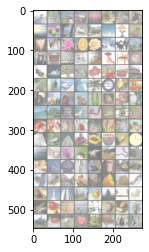

tensor([49, 33, 72, 51, 71, 92, 15, 14, 23,  0, 71, 75, 81, 69, 40, 43, 92, 97,
        70, 53, 70, 49, 75, 29, 21, 16, 39,  8,  8, 70, 20, 61, 41, 93, 56, 73,
        58, 11, 25, 37, 63, 24, 49, 73, 56, 22, 41, 58, 75, 17,  4,  6,  9, 57,
         2, 32, 71, 52, 42, 69, 77, 27, 15, 65,  7, 35, 43, 82, 63, 92, 66, 90,
        67, 91, 32, 32, 82, 10, 77, 22, 71, 78, 54,  6, 29, 89, 78, 33, 11, 67,
        22, 18, 27, 21, 13, 21, 50, 75, 37, 35, 26, 83, 47, 95, 43, 69, 76, 17,
        57, 59, 25, 20, 27,  0,  9, 71,  8, 43, 57, 56, 85, 10, 19, 92, 33, 20,
        21, 50])

In [4]:
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(test_loader)
images = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images[0]))
images[1]

In [4]:
class ConvNet(nn.Module):
    """CNN."""

    def __init__(self):
        """CNN Builder."""
        super(ConvNet, self).__init__()

        

            # Conv Layer block 1
        self.conv1=nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        self.bn1=nn.BatchNorm2d(32)
            #nn.ReLU(inplace=True),
        self.conv1_1=nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
            #nn.ReLU(inplace=True),
        self.pool=nn.MaxPool2d(kernel_size=2, stride=2)

            # Conv Layer block 2
        self.conv2=nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.bn2=nn.BatchNorm2d(128)
            #nn.ReLU(inplace=True),
        self.conv2_1=nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1)
            #nn.ReLU(inplace=True),
            #nn.MaxPool2d(kernel_size=2, stride=2),
            #nn.Dropout2d(p=0.05),

             #Conv Layer block 3
        self.conv3=nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1)
        self.bn3=nn.BatchNorm2d(256)
            #nn.ReLU(inplace=True),
        self.conv3_1=nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1)
            #nn.ReLU(inplace=True),
            #nn.MaxPool2d(kernel_size=2, stride=2),
        


        self.fc_layer = nn.Sequential(
            nn.Dropout(p=0.1),
            nn.Linear(4096, 1024),
            nn.ReLU(inplace=True),
            nn.Linear(1024, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.1),
            nn.Linear(512, 100)
        )


    def forward(self, x):
        """Perform forward."""
        
        # conv layers
        #x = self.conv_layer(x)
        x=F.relu(self.bn1(self.conv1(x)))
        x=self.pool(F.relu(self.conv1_1(x)))
        x=F.relu(self.bn2(self.conv2(x)))
        x=self.pool(F.relu(self.conv2_1(x)))
        x=F.relu(self.bn3(self.conv3(x)))
        x=self.pool(F.relu(self.conv3_1(x)))

        # flatten
        x = x.view(x.size(0), -1)
        
        # fc layer
        x = self.fc_layer(x)

        return x


model = ConvNet().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

n_total_steps = len(train_loader)
for epoch in range(num_epochs):
    for i, (images) in enumerate(train_loader):
        # origin shape: [4, 3, 32, 32] = 4, 3, 1024
        # input_layer: 3 input channels, 6 output channels, 5 kernel size
        images[0] = images[0].to(device)
        images[1] = images[1].to(device)

        # Forward pass
        outputs = model.forward(images[0])
        loss = criterion(outputs, images[1])

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        del images[0]
        torch.cuda.empty_cache()
        del outputs
        torch.cuda.empty_cache()
        
    print(loss)
    del loss
    torch.cuda.empty_cache()
       # if (i+1) % 2000 == 0:
        #    print (f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{n_total_steps}], Loss: {loss.item():.4f}')

print('Finished Training')
PATH = './cnn.pth'
torch.save(model, PATH)

with torch.no_grad():
    n_correct = 0
    n_samples = 0
    n_class_correct = [0 for i in range(100)]
    n_class_samples = [0 for i in range(100)]
    for images in test_loader:
        images[0] = images[0].to(device)
        images[1] = images[1].to(device)
        outputs = model.forward(images[0])
        # max returns (value ,index)
        _, predicted = torch.max(outputs, 1)
        n_samples += images[1].size(0)
        n_correct += (predicted == images[1]).sum().item()
        
        #for i in range(batch_size):
         #   label = images[1][i]
          #  pred = predicted[i]
           # if (label == pred):
            #    n_class_correct[label] += 1
            #n_class_samples[label] += 1

    acc = 100.0 * n_correct / n_samples
    print(f'Accuracy of the network: {acc} %')


tensor(3.4660, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(3.1530, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(2.5626, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(2.2617, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.9757, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(2.0318, device='cuda:0', grad_fn=<NllLossBackward>)
Finished Training


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:402: UserWarning: Couldn't retrieve source code for container of type ConvNet. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Accuracy of the network: 40.46 %


In [8]:
torch.cuda.is_available()
#model=torch.load('cnn.pth')


True

In [14]:
#import torch
predicted=[]
#device = torch.device("cpu")
#model.to(device)
model.eval()
for images in test_loader:
        images[0] = images[0].to(device)
        #images[1] = images[1]
        outputs = model(images[0])
        # max returns (value ,index)
        
        predicted.append((torch.argmax(outputs, 1)).tolist())
        del images[0]
        torch.cuda.empty_cache()
#print(predicted)
finpred=[]
for i in range(len(predicted)):
  for p in range(len(predicted[i])):
    finpred.append(predicted[i][p])
print(len(finpred)) 
#finpred=[int(i) for i in finpred]
print(finpred)

10000
[95, 80, 15, 19, 71, 6, 38, 7, 71, 83, 87, 75, 81, 69, 40, 43, 92, 97, 70, 53, 70, 49, 75, 59, 21, 16, 39, 8, 8, 84, 20, 61, 41, 91, 56, 8, 58, 35, 25, 37, 63, 76, 49, 30, 56, 22, 48, 13, 19, 38, 4, 6, 9, 57, 36, 64, 71, 47, 42, 30, 77, 32, 31, 38, 45, 65, 43, 92, 63, 92, 48, 89, 36, 91, 93, 32, 82, 10, 77, 61, 71, 50, 54, 6, 29, 13, 99, 59, 5, 30, 21, 18, 27, 21, 90, 21, 4, 7, 37, 46, 8, 53, 47, 86, 4, 69, 76, 17, 83, 59, 25, 20, 32, 0, 9, 71, 8, 43, 0, 56, 90, 84, 38, 62, 33, 20, 21, 66, 1, 64, 84, 16, 81, 66, 3, 91, 60, 97, 47, 23, 4, 35, 52, 31, 4, 95, 13, 39, 91, 58, 58, 22, 66, 60, 45, 97, 13, 20, 24, 4, 36, 8, 20, 10, 72, 96, 54, 50, 64, 83, 9, 45, 27, 19, 95, 45, 4, 71, 18, 40, 31, 75, 45, 64, 10, 69, 35, 30, 84, 48, 58, 7, 81, 13, 94, 24, 90, 63, 7, 87, 6, 78, 68, 60, 6, 60, 69, 31, 72, 93, 72, 98, 49, 90, 97, 33, 53, 95, 16, 81, 94, 68, 79, 77, 37, 44, 0, 19, 80, 71, 90, 53, 59, 24, 64, 11, 97, 34, 82, 31, 23, 24, 34, 72, 46, 92, 38, 91, 64, 39, 91, 16, 31, 76, 67, 38, 

In [15]:
import pandas as pd
res = []
for i in range(1,10001):
    res.append([i-1,int(finpred[i-1])])
res = pd.DataFrame(res, columns = ['Id', 'Category']) 
print(res)
res.to_csv('fin.csv', index = False)

        Id  Category
0        0        95
1        1        80
2        2        15
3        3        19
4        4        71
...    ...       ...
9995  9995        92
9996  9996        63
9997  9997        18
9998  9998        78
9999  9999        70

[10000 rows x 2 columns]
